In [12]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
import random
from sklearn.metrics import classification_report
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
from statsmodels.stats.multitest import fdrcorrection_twostage
%matplotlib inline

In [13]:
#Reading the csv file
df_train = pd.read_csv("C:/MITA Spring 19/Turkoz/Capstone/Drug_Dataset/train_raw/train_csv.csv")
df_test = pd.read_csv("C:/MITA Spring 19/Turkoz/Capstone/Drug_Dataset/test_raw/test_raw.csv")

#Shape of data
print("Shape of train data: ",df_train.shape)
print("Shape of test data: ",df_test.shape)
df_train.head()

Shape of train data:  (161297, 7)
Shape of test data:  (53766, 7)


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [14]:
#Computing the new column sentinment on basis of rating 
def sentiment(x):
    if x>5:
        return 1
    else:
        return 0
df_train['sentiment'] = df_train['rating'].apply(lambda x: sentiment(x))
df_test['sentiment'] = df_test['rating'].apply(lambda x: sentiment(x))

df_train['sentiment'].dtypes

dtype('int64')

In [15]:
#Checking the train dataframe
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


In [16]:
#Checking the test dataframe
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,1
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,1
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,1
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,1
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,1


# Exploratory Data Analysis

In [32]:
#Analyze the count of sentiment
df_train.groupby('sentiment').size()



sentiment
0     48088
1    113209
dtype: int64

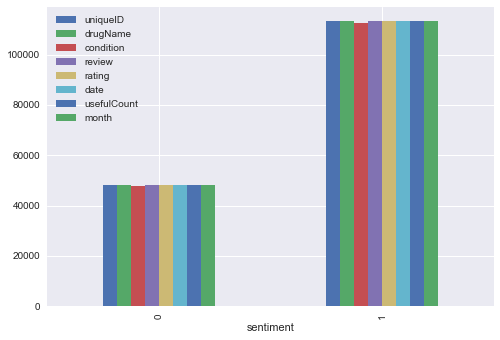

In [33]:
#Visualizing sentiment for each features of Drug dataset
df_train.groupby('sentiment').count().plot.bar()

In [34]:
#converting the date feature to appropriate date time
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['month'] = df_train['date'].apply(lambda x: x.month)
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,month
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,1,5
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,1,4
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,0,12
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,1,11
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,1,11


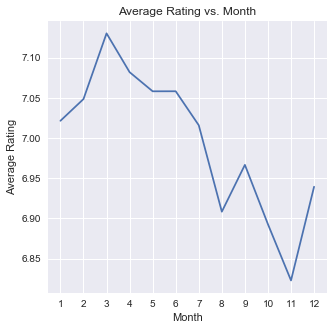

In [35]:
#Visualize the rating feature monthly
fig, ax = plt.subplots(1,1, figsize=(5,5))

plt.style.use('seaborn')

# Score by Moth


ax.plot(df_train.groupby('month').rating.mean())
ax.set_ylabel('Average Rating')
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))
ax.set_title('Average Rating vs. Month')



plt.show()

Text(0.5, 1.0, 'Number of comments posting against date')

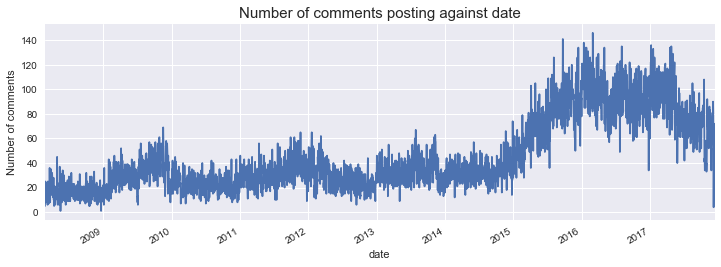

In [36]:
#Visualizing number of comments/review by year
df_train.groupby('date')['review'].size().plot(figsize=(12,4))
plt.ylabel('Number of comments')
plt.title("Number of comments posting against date",fontsize=15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

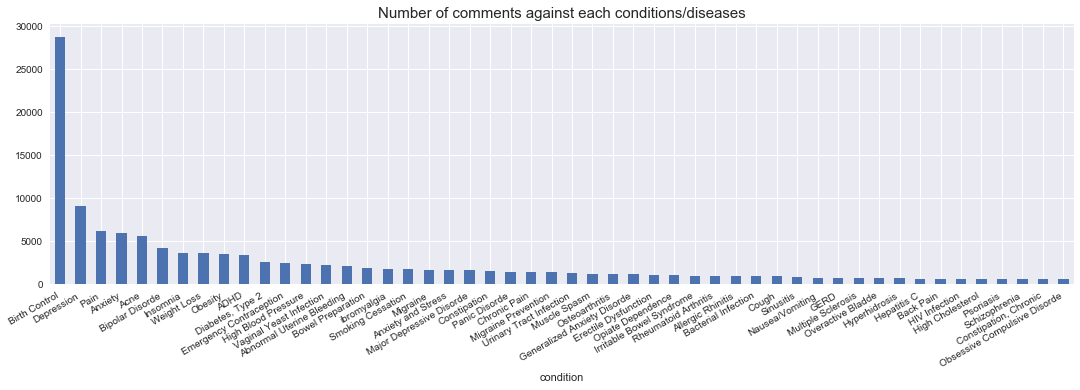

In [77]:
# Analyze the counts of comments against each condition of disease
df_condition_for_month = pd.DataFrame(df_train.groupby(['condition','month']).size()).reset_index()

df_comments = df_condition_for_month.pivot_table(index='condition',columns='month',values=0)

fig = plt.figure(figsize=(15,5))
df_comments.sum(1).sort_values(ascending=False).iloc[:50].plot(kind='bar')
plt.title("Number of comments against each conditions/diseases",fontsize=15)
plt.tight_layout()
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.xticks(fontsize=10)

# plt.savefig("Plot/num_comments_each_condition.png")

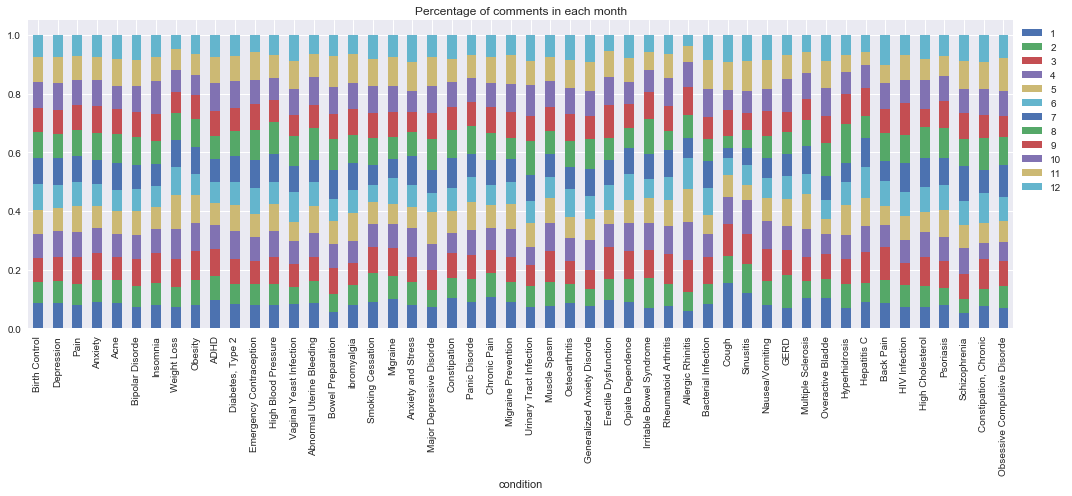

In [46]:
#Percentage of comments in each month for each disease
n = 50
top_n_index = df_comments.sum(1).sort_values(ascending=False).iloc[:n].index
top_comments = df_comments.loc[top_n_index]
top_comments_percentage = top_comments.div(top_comments.sum(1), axis=0)
top_comments_percentage.plot.bar(stacked=True, figsize=(15,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Percentage of comments in each month")
plt.tight_layout()

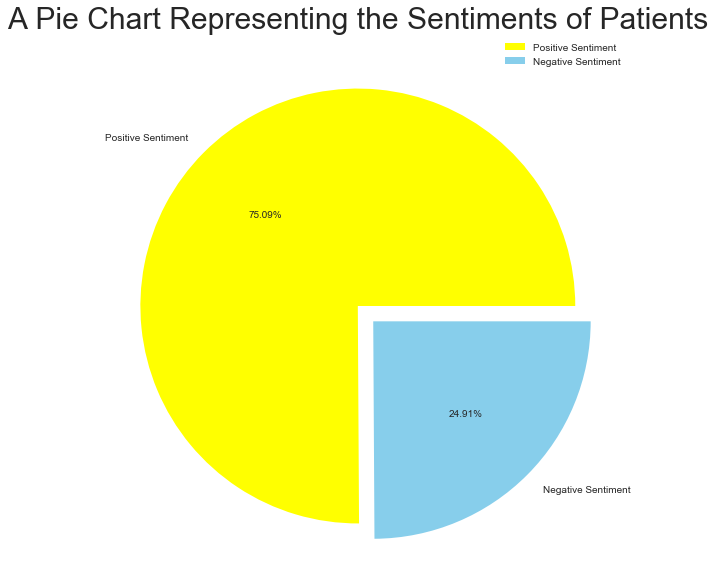

In [75]:
# a pie chart to represent the sentiments of the patients

size = [161491, 53572]
colors = ['yellow', 'skyblue']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Sentiments of Patients', fontsize = 30)
plt.legend()
plt.show()

In [82]:
## avg of comments for each condition in each month
df_comments_sorted = df_comments.loc[df_comments.sum(1).sort_values(ascending=False).index]
df_comments_sorted.sum() / len(df_comments_sorted)

month
1     15.356335
2     13.541855
3     15.686652
4     15.442308
5     15.020362
6     14.348416
7     15.580317
8     16.380090
9     15.158371
10    15.804299
11    15.606335
12    13.520362
dtype: float64

# Chi-Squared Test

In [95]:
sum_months = df_comments_sorted.sum()
all_sum = sum_months.sum()

i = 0 
#df_con_mon_pivot_sorted.iloc[i,:]
expected = df_comments_sorted.sum(0) * (df_comments_sorted.iloc[i,:].sum() / all_sum)
observed = df_comments_sorted.iloc[i,:]
chisquare(observed,f_exp=expected)

Power_divergenceResult(statistic=38.935465364569865, pvalue=5.4327938627447377e-05)

In [96]:
sum_months = df_comments_sorted.sum()
all_sum = sum_months.sum()
chi_result =[]

## only take T > 5 (the cell need 5 records at least)
df_comments_sorted_T5 = df_comments_sorted[(df_comments_sorted > 5).all(1)]
df_comments_sorted_T5.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
condition,,,,,,,,,,,,
Birth Control,2458.0,2089.0,2327.0,2356.0,2441.0,2477.0,2542.0,2627.0,2348.0,2492.0,2494.0,2137.0
Depression,773.0,684.0,753.0,808.0,712.0,707.0,823.0,740.0,749.0,827.0,819.0,674.0
Pain,489.0,443.0,563.0,529.0,537.0,506.0,541.0,556.0,514.0,519.0,514.0,434.0
Anxiety,522.0,445.0,546.0,515.0,431.0,441.0,496.0,547.0,538.0,511.0,464.0,448.0
Acne,490.0,429.0,444.0,435.0,431.0,412.0,518.0,542.0,477.0,437.0,511.0,462.0


In [97]:
# compare expected and observed using chi-square test
for idx in df_comments_sorted_T5.index:
    ## use 
    expected = df_comments_sorted.sum(0) * (df_comments_sorted.loc[idx,:].sum() / all_sum)
    observed = df_comments_sorted_T5.loc[idx,:]
    chi_result.append([idx,chisquare(observed,f_exp=expected)])

In [98]:
df_chi = pd.DataFrame([[a[0],a[1].statistic,a[1].pvalue] for a in chi_result])
df_chi.columns = ['condition','statistic','pvalue']
df_chi['adj_pvalue'] = fdrcorrection_twostage(df_chi['pvalue'])[1]
df_chi.head()


,condition,statistic,pvalue,adj_pvalue
0,Birth Control,38.935465,0.000054,0.000293
1,Depression,19.054616,0.060120,0.083805
2,Pain,9.238257,0.599910,0.425463
3,Anxiety,20.705844,0.036550,0.056828
4,Acne,29.811602,0.001696,0.004424


In [99]:

df_chi_sorted = df_chi[df_chi['adj_pvalue'] < 0.05].sort_values('pvalue')

df_chi_sorted.head(10)

,condition,statistic,pvalue,adj_pvalue
7,Weight Loss,145.652500,1.149992e-25,9.297688e-24
35,Cough,129.962039,1.771886e-22,7.162849e-21
33,Allergic Rhinitis,89.940100,1.712822e-14,4.616054e-13
36,Sinusitis,72.581047,3.936670e-11,7.956994e-10
72,Cough and Nasal Congestion,71.094673,7.562344e-11,1.222831e-09
68,Herpes Simplex,57.745517,2.424612e-08,3.267165e-07
8,Obesity,54.759136,8.577515e-08,9.907030e-07
6,Insomnia,53.858426,1.252668e-07,1.265978e-06
53,Bronchitis,50.674949,4.731868e-07,4.250795e-06
13,Vaginal Yeast Infection,48.344293,1.239355e-06,1.002018e-05


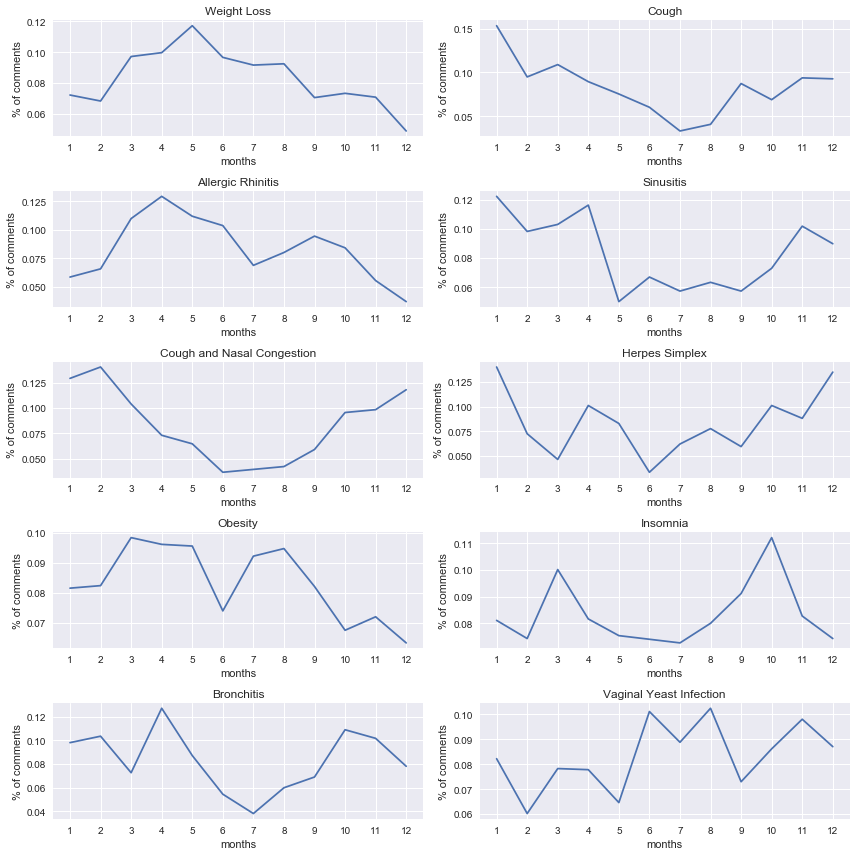

In [100]:
plt.figure(figsize=(12,12))
i =1
for idx in df_chi_sorted['condition'][:10]:
    
    each = df_comments_sorted_T5.loc[idx,:]/df_comments_sorted_T5.loc[idx,:].sum()
    
    plt.subplot(5, 2, i)
    plt.title(idx)
    plt.plot(each)
    plt.xticks(np.arange(1,13,1))
    plt.xlabel('months')
    plt.ylabel('% of comments')
    i = i +1
    
plt.tight_layout()

In [101]:
df_train.describe(include="all")

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,month
count,161297.000000,161297,160398,161297,161297.000000,161297,161297.000000,161297.000000,161297.000000
unique,NaN,3436,884,112329,NaN,3579,NaN,NaN,NaN
top,NaN,Levonorgestrel,Birth Control,"""Good""",NaN,2016-03-01 00:00:00,NaN,NaN,NaN
freq,NaN,3657,28788,33,NaN,146,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2008-02-24 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-12-12 00:00:00,NaN,NaN,NaN
mean,115923.585305,NaN,NaN,NaN,6.994377,NaN,28.004755,0.701867,6.507709
std,67004.445170,NaN,NaN,NaN,3.272329,NaN,36.403742,0.457440,3.417574
min,2.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,0.000000,1.000000
25%,58063.000000,NaN,NaN,NaN,5.000000,NaN,6.000000,0.000000,4.000000


In [1]:
X_train = ["this is a para",'graph is a method']

In [3]:
count = {}

for line in X_train:
    for word in line.split():
        if word not in count.keys():
            count[word]=1
        else:
            count[word]+=1

In [4]:
count

{'this': 1, 'is': 2, 'a': 2, 'para': 1, 'graph': 1, 'method': 1}